# Tracer budgets

do some tracer budget calculations to assess the size of the source, relative to the other terms. 

In [1]:
# load modules 
import numpy as np
import xarray as xr
from xmitgcm import open_mdsdataset
from matplotlib import pyplot as plt
from matplotlib import colors, ticker, cm
from matplotlib.colors import LogNorm
%matplotlib inline
import os 
from xgcm import Grid
from xarrayutils import aggregate
import copy
# Pseudo Inversion 
from scipy.linalg import pinv, eig

In [3]:
# Load Means 
Model_Tav = xr.open_dataset('./outputs_ncfiles/Model_Tav.nc')
Trac_Tav = xr.open_dataset('./outputs_ncfiles/Trac_Tav.nc')

In [28]:
Model_Tav

<xarray.Dataset>
Dimensions:              (XC: 400, XG: 400, YC: 400, YG: 400, Z: 40, Zl: 40, Zp1: 41, Zu: 40, layer_1TH_bounds: 43, layer_1TH_center: 42, layer_1TH_interface: 41)
Coordinates:
  * XC                   (XC) float32 2500.0 7500.0 ... 1992500.0 1997500.0
  * YC                   (YC) float32 2500.0 7500.0 ... 1992500.0 1997500.0
  * XG                   (XG) float32 0.0 5000.0 10000.0 ... 1990000.0 1995000.0
  * YG                   (YG) float32 0.0 5000.0 10000.0 ... 1990000.0 1995000.0
  * Z                    (Z) float32 -5.0 -15.0 -25.0 ... -2830.5 -2933.5
  * Zp1                  (Zp1) float32 0.0 -10.0 -20.0 ... -2882.0 -2985.0
  * Zu                   (Zu) float32 -10.0 -20.0 -30.0 ... -2882.0 -2985.0
  * Zl                   (Zl) float32 0.0 -10.0 -20.0 ... -2779.0 -2882.0
    rA                   (YC, XC) float32 ...
    dxG                  (YG, XC) float32 ...
    dyG                  (YC, XG) float32 ...
    Depth                (YC, XC) float32 ...
    rAz   

In [4]:
Trac_Tav

<xarray.Dataset>
Dimensions:              (XC: 400, XG: 400, YC: 400, YG: 400, Z: 40, Zl: 40, Zp1: 41, Zu: 40, layer_1TH_bounds: 43, layer_1TH_center: 42, layer_1TH_interface: 41)
Coordinates:
  * XC                   (XC) float32 2500.0 7500.0 ... 1992500.0 1997500.0
  * YC                   (YC) float32 2500.0 7500.0 ... 1992500.0 1997500.0
  * XG                   (XG) float32 0.0 5000.0 10000.0 ... 1990000.0 1995000.0
  * YG                   (YG) float32 0.0 5000.0 10000.0 ... 1990000.0 1995000.0
  * Z                    (Z) float32 -5.0 -15.0 -25.0 ... -2830.5 -2933.5
  * Zp1                  (Zp1) float32 0.0 -10.0 -20.0 ... -2882.0 -2985.0
  * Zu                   (Zu) float32 -10.0 -20.0 -30.0 ... -2882.0 -2985.0
  * Zl                   (Zl) float32 0.0 -10.0 -20.0 ... -2779.0 -2882.0
    rA                   (YC, XC) float32 ...
    dxG                  (YG, XC) float32 ...
    dyG                  (YC, XG) float32 ...
    Depth                (YC, XC) float32 ...
    rAz   

In [8]:
grid = Grid(Trac_Tav, periodic='XC')

In [25]:
# For tracer 1 
dx = 5e3 
dy = 5e3 
dz = Trac_Tav.drF
divflux = (grid.diff(Trac_Tav.UTRAC01, 'X')/dx + grid.diff(Trac_Tav.VTRAC01,'Y', boundary='extend')/dy +
           -grid.interp(grid.diff(Trac_Tav.WTRAC01, 'Z', boundary='extend'), 'Z', boundary='extend')/dz)

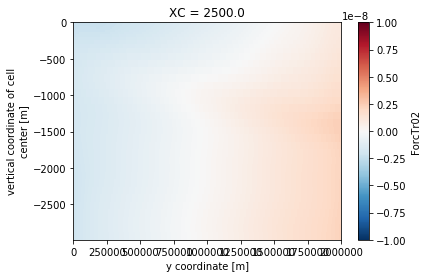

In [48]:
Trac_Tav.ForcTr02.sel(XC=0, method='nearest').plot(vmin=-1e-8)

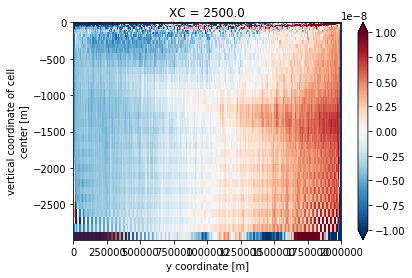

In [54]:
divflux.sel(XC=0, method='nearest').plot(vmin=-1e-8)

The divergence of the total flux cancels out the forcing almost completely, this is obvious as there is nothing else to maintain the steady balance. 

We need to check how the eddy flux (not the full) divergence compares to forcing.

In [49]:
UbarCbar = Model_Tav.uVeltave * grid.interp(Trac_Tav.TRAC02, 'X')
VbarCbar = Model_Tav.vVeltave * grid.interp(Trac_Tav.TRAC02, 'Y', boundary='extend')
WbarCbar = Model_Tav.wVeltave * grid.interp(Trac_Tav.TRAC02, 'Z', boundary='extend')

In [50]:
UpCp = Trac_Tav.UTRAC02 - UbarCbar
VpCp = Trac_Tav.VTRAC02 - VbarCbar
WpCp = grid.interp(Trac_Tav.WTRAC02, 'Z', boundary='extend') - WbarCbar

In [51]:
divflux_mean = (grid.diff(UbarCbar, 'X')/dx + grid.diff(VbarCbar,'Y', boundary='extend')/dy +
               -grid.diff(WbarCbar, 'Z', boundary='extend')/dz)

In [52]:
divflux_eddy = (grid.diff(UpCp, 'X')/dx + grid.diff(VpCp,'Y', boundary='extend')/dy +
               -grid.diff(WpCp, 'Z', boundary='extend')/dz)

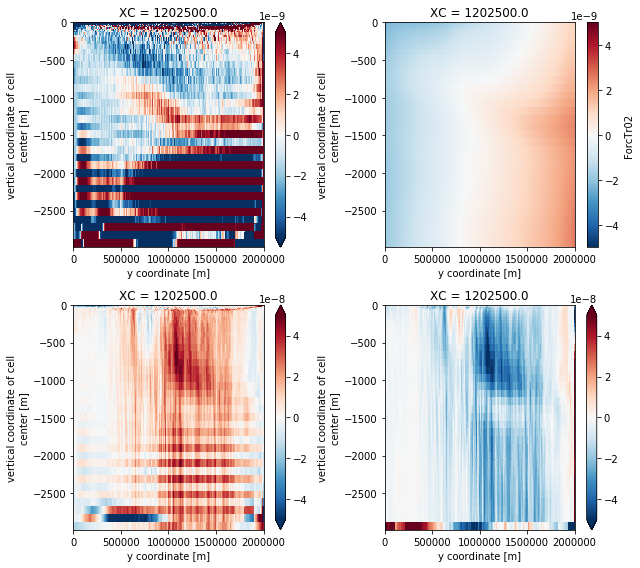

In [61]:
plt.figure(figsize=(9,8))
plt.subplot(221)
(divflux_eddy + divflux_mean).sel(XC=1200e3, method='nearest').plot(vmin=-5e-9)

plt.subplot(222)
Trac_Tav.ForcTr02.sel(XC=1200e3, method='nearest').plot(vmin=-5e-9)

plt.subplot(223)
(divflux_eddy).sel(XC=1200e3, method='nearest').plot(vmin=-5e-8)

plt.subplot(224)
(divflux_mean).sel(XC=1200e3, method='nearest').plot(vmin=-5e-8)

plt.tight_layout()

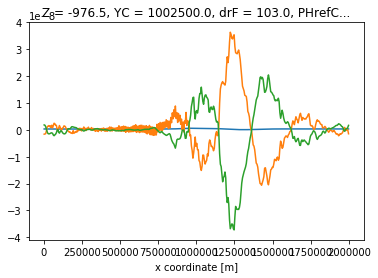

In [68]:
Trac_Tav.ForcTr02.sel(Z=-1000, YC=1000e3, method='nearest').plot()
(divflux_eddy).sel(Z=-1000, YC=1000e3, method='nearest').plot()
(divflux_mean).sel(Z=-1000, YC=1000e3, method='nearest').plot()


(-1e-09, 1e-09)

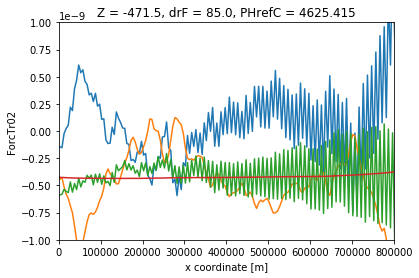

In [79]:
(divflux_eddy).sel(Z=-500, method='nearest').sel(YC=slice(600e3,1500e3)).mean('YC').plot()
(divflux_mean).sel(Z=-500, method='nearest').sel(YC=slice(600e3,1500e3)).mean('YC').plot()
(divflux_eddy+divflux_mean).sel(Z=-500, method='nearest').sel(YC=slice(600e3,1500e3)).mean('YC').plot()
(Trac_Tav.ForcTr02).sel(Z=-500, method='nearest').sel(YC=slice(600e3,1500e3)).mean('YC').plot()
plt.xlim([0, 800e3])
plt.ylim([-1e-9, 1e-9])

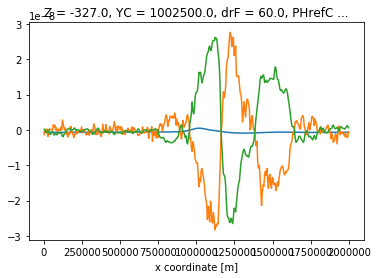

In [69]:
Trac_Tav.ForcTr02.sel(Z=-300, YC=1000e3, method='nearest').plot()
(divflux_eddy).sel(Z=-300, YC=1000e3, method='nearest').plot()
(divflux_mean).sel(Z=-300, YC=1000e3, method='nearest').plot()


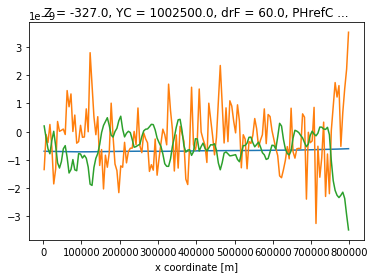

In [70]:
Trac_Tav.ForcTr02.sel(Z=-300, YC=1000e3, method='nearest').sel(XC=slice(0,800e3)).plot()
(divflux_eddy).sel(Z=-300, YC=1000e3, method='nearest').sel(XC=slice(0,800e3)).plot()
(divflux_mean).sel(Z=-300, YC=1000e3, method='nearest').sel(XC=slice(0,800e3)).plot()

# Result

In the mean tracer, at steady state, the divergence of flux is balanced by the forcing. In regions of weak eddies (upstream) the mean and eddy flux divergences are small, and comparable to the forcing. However, according to 